In [105]:
import pickle, math

import h5py
import numpy as np
import tensorflow_datasets as tfds

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import seaborn as sns
sns.set_theme(style='ticks', font_scale=1.3)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + [mcolors.to_rgba(mcolors.CSS4_COLORS['lime']), mcolors.to_rgba(mcolors.CSS4_COLORS['sandybrown'])]

import iris_train

from importlib import reload
reload(iris_train);

In [3]:
iris_ds = tfds.load('iris', split='train', batch_size=-1, shuffle_files=True)

x = iris_ds['features'].numpy()
y = iris_ds['label'].numpy()

x_train, x_test = x[:120], x[120:]
y_train, y_test = y[:120], y[120:]

input_dim = 4
h_dim = 10
output_dim = 3
iho = (input_dim, h_dim, output_dim)

2023-10-11 21:34:06.341194: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [4]:
# Style settings

plt.rcParams['text.usetex'] = True

# 4 — small $\eta$

1e-08


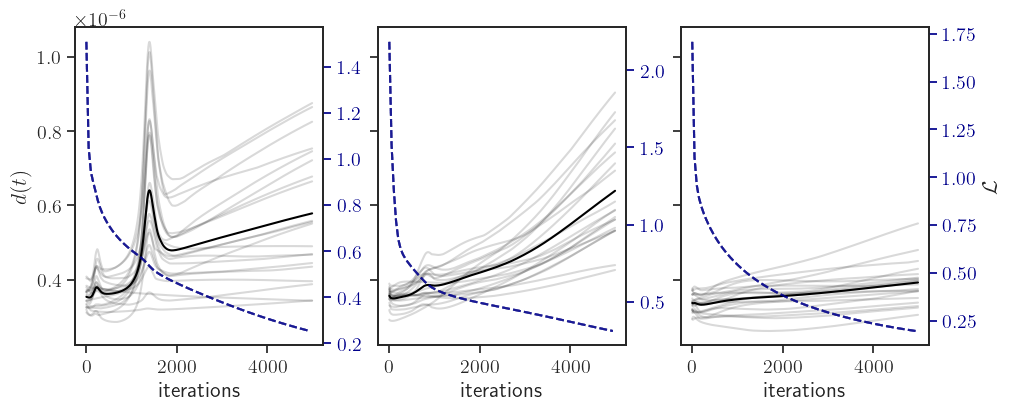

In [38]:
# Example trajectories
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']
    # loss_ds = f['loss']

    epsilons = f.attrs['epsilons']
    n_init = f.attrs['n_init']

    idx = 10
    print(epsilons[idx])

    ws_8 = weights_ds[idx, ...]
    dists_8 = np.squeeze(iris_train.get_dists_dataset_frommat(ws_8[None, :]), axis=0)
    model = iris_train.get_empty_model(h_dim)
    period = 50
    losses_8 = np.empty((3, f.attrs['n_pert'], f.attrs['n_sample_points']//period))
    for i_init in range(3) :
        for i_pert in range(f.attrs['n_pert']) :
            losses_8[i_init,i_pert] = iris_train.get_loss_from_matrices(ws_8[i_init,i_pert,::period], model, x_train, y_train)

fig, ax = plt.subplots(1, 3, figsize=(10,4), constrained_layout=True, sharey=True)
# fig, ax = plt.subplots(1, 3, figsize=(12,4), constrained_layout=True)

for i_init in range(n_init)[:3] :
    ax[i_init].plot(dists_8[i_init, :, :].T, color='black', alpha=0.15, zorder=4)
    ax[i_init].plot(np.mean(dists_8[i_init, :, :].T, axis=1), color='black', zorder=5)

    ax_ls = ax[i_init].twinx()
    ax_ls.plot(np.arange(0, dists_8.shape[-1], period), losses_8[i_init].T, color='darkblue', ls='--', alpha=0.1)
    ax_ls.tick_params(colors='darkblue', which='both')

    ax[i_init].set_xlabel('iterations')
ax[0].set_ylabel('$d(t)$')
ax_ls.set_ylabel("$\mathcal{L}$")

plt.savefig('../report/figures/example.pdf')

## 4.2 — Dependence on $\epsilon$

[1.e-14 1.e-10 1.e-06 1.e-02]


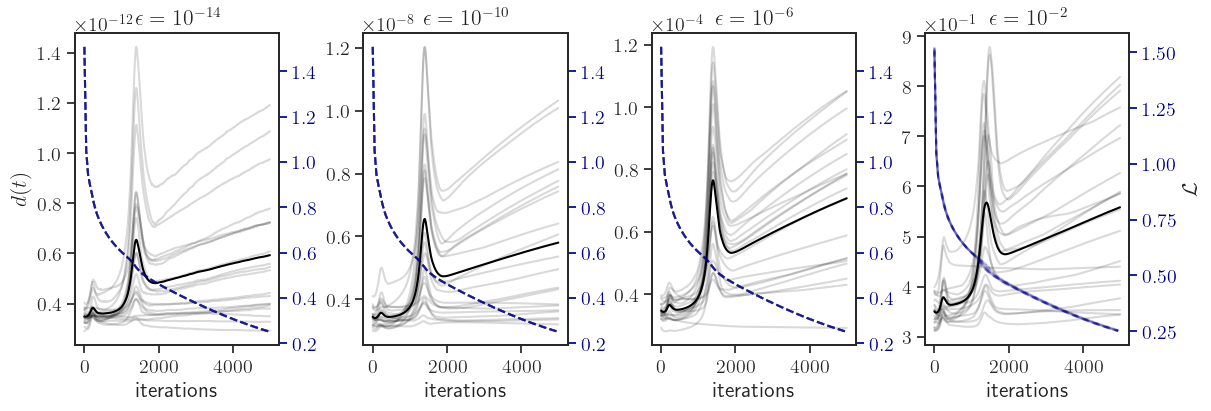

In [39]:
# Different epsilon
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']

    i_init = 0

    epsilons = f.attrs['epsilons']
    eps_indices = [4, 8, 12, 16]
    print(epsilons[eps_indices])

    ws = weights_ds[eps_indices, i_init, ...]
    dists = np.squeeze(iris_train.get_dists_dataset_frommat(ws[:, None, ...]), axis=1)
    model = iris_train.get_empty_model(h_dim)
    period = 50
    losses = np.empty((len(eps_indices), f.attrs['n_pert'], f.attrs['n_sample_points']//period))
    for i_eps in range(len(eps_indices)) :
        for i_pert in range(f.attrs['n_pert']) :
            losses[i_eps,i_pert] = iris_train.get_loss_from_matrices(ws[i_eps,i_pert,::period], model, x_train, y_train)

fig, axs = plt.subplots(1, len(eps_indices), figsize=(12,4), constrained_layout=True)

for i, i_eps in enumerate(eps_indices) :
    d = dists[i]

    ax = axs[i]
    ax.set_title("  $\epsilon = 10^{" + str(int(math.log10(epsilons[i_eps]))) + "}$  ")

    ax.plot(d.T, color='black', alpha=0.15, zorder=4)
    ax.plot(np.mean(d.T, axis=1), color='black', zorder=5)

    ax.set_xlabel('iterations')
    # ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    ax_ls = ax.twinx()
    ax_ls.plot(np.arange(0, dists.shape[-1], period), losses[i].T, color='darkblue', ls='--', alpha=0.1)
    ax_ls.tick_params(colors='darkblue', which='both')
axs[0].set_ylabel('$d(t)$')
ax_ls.set_ylabel("$\mathcal{L}$")

plt.savefig('../report/figures/epsilon_difference.pdf')

[1.e-15 1.e-14 1.e-13 1.e-12 1.e-11 1.e-10 1.e-09 1.e-08 1.e-07 1.e-06
 1.e-05 1.e-04 1.e-03 1.e-02]


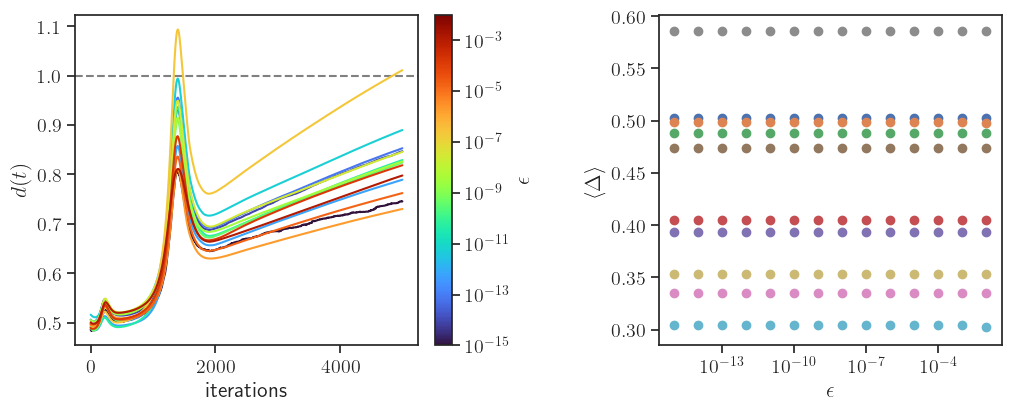

In [43]:
# Normalized by epsilon — distances and displacements
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']

    n_init = f.attrs['n_init']
    n_pert = f.attrs['n_pert']
    i_init = 0

    epsilons = f.attrs['epsilons']
    # eps_indices = [4, 8, 12, 16]
    eps_indices = range(3, len(epsilons)-5)
    print(epsilons[eps_indices])

    ws = weights_ds[eps_indices, i_init, ...]
    ws_all = weights_ds[eps_indices]
    dists = np.squeeze(iris_train.get_dists_dataset_frommat(ws[:, None, ...]), axis=1)
    # model = iris_train.get_empty_model(h_dim)
    # losses = np.empty((len(eps_indices), f.attrs['n_pert'], f.attrs['n_sample_points']))
    # for i_eps in range(len(eps_indices)) :
    #     for i_pert in range(f.attrs['n_pert']) :
    #         losses[i_eps,i_pert] = iris_train.get_loss_from_matrices(ws[i_eps,i_pert], model, x_train, y_train)

# fig, axs = plt.subplots(1, len(eps_indices), figsize=(12,4), constrained_layout=True)
fig, axs = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)
fig.set_constrained_layout_pads(wspace=0.1)

norm_factors = 70 * epsilons    # number of neurons * pert radius = max pert distance

cmap = mpl.colormaps['turbo']
norm = mpl.colors.LogNorm(epsilons[eps_indices[0]], epsilons[eps_indices[-1]])

ax = axs[0]
# ax.set_title(f'Average weight trajectories, different $\epsilon$')
for i, i_eps in enumerate(eps_indices) :

    d = dists[i]/norm_factors[i_eps]
    # ax.plot(np.mean(d.T, axis=1), color='black', alpha=0.7, zorder=5)
    ax.plot(np.mean(d.T, axis=1), color=cmap(i/len(eps_indices)), alpha=1, zorder=5)

    ax.set_xlabel('iterations')
    ax.set_ylabel('$d(t)$')

    # ax.twinx().plot(losses[i].T, color='darkblue', ls='--', alpha=0.1)

plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, label='$\epsilon$')
ax.axhline(1, ls='--', color='gray')

###

ax = axs[1]
# ax.set_title(f'Mean and std of displacements $\Delta$')

for i_init in range(n_init) :
    delta_means = []
    delta_stds = []
    for i, i_eps in enumerate(eps_indices) :
        deltas = []
        for i_pert in range(n_pert+1) :
            ws_pert = ws_all[i,i_init,i_pert]
            w_diff_sum = np.sum(np.abs(ws_pert[-1] - ws_pert[0])) / np.sum(np.abs(ws_pert[0]))     # L1 norm
            deltas.append(w_diff_sum)
        delta_means.append(np.mean(deltas))
        delta_stds.append(np.std(deltas))

    # TODO: Find a better way to visualize stds?

    ax.errorbar(epsilons[eps_indices], delta_means, yerr=delta_stds, ls='', fmt='o')

ax.set_xlabel('$\epsilon$')
ax.set_ylabel('$\langle\Delta\\rangle$')
ax.set_xscale('log')

# plt.subplots_adjust(wspace=2)
plt.savefig('../report/figures/epsilon_norm.pdf')

Check distribution of pairwise distances for above at different points (start, bump, divergence)

/var/folders/17/j4v928fn43lgly2gzf268j480000gn/T/ipykernel_84531/1583606264.py:36: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax_ls.get_shared_y_axes().join(*twins)


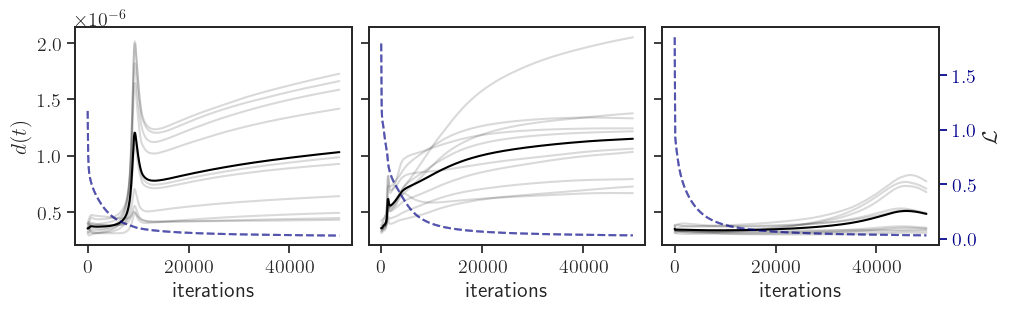

In [41]:
# Long runs
with h5py.File('results/long_run.h5', 'r') as f :
    weights_ds = f['weights']

    epsilon = f.attrs['epsilon']
    N = 70
    d0_exp = N * epsilon / 2

    dists = np.squeeze(iris_train.get_dists_dataset_frommat(np.expand_dims(weights_ds, 0)))

    loss_sample_period = 100
    model = iris_train.get_empty_model(h_dim)
    losses = np.empty((f.attrs['n_init'], f.attrs['n_pert'], f.attrs['n_sample_points']//loss_sample_period))
    for i_init in range(f.attrs['n_init']) :
        for i_pert in range(f.attrs['n_pert']) :
            losses[i_init,i_pert] = iris_train.get_loss_from_matrices(weights_ds[i_init,i_pert,::loss_sample_period], model, x_train, y_train)

    fig, axs = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True, sharey=True)

    twins = []
    for i_init in range(f.attrs['n_init']) :
        ax = axs[i_init]
        d = dists[i_init,:,::loss_sample_period]
        iters = np.arange(0, f.attrs['n_sample_points'], loss_sample_period)

        ax.plot(iters, d.T, color='black', alpha=0.15, zorder=4)
        ax.plot(iters, np.mean(d.T, axis=1), color='black', zorder=5)

        ax.set_xlabel('iterations')

        ax_ls = ax.twinx()
        ax_ls.plot(iters, losses[i_init].T, color='darkblue', ls='--', alpha=0.1)
        ax_ls.tick_params(colors='darkblue', which='both')
        twins.append(ax_ls)
    ax_ls.set_ylabel("$\mathcal{L}$")
    ax_ls.get_shared_y_axes().join(*twins)
    for ax in twins[:-1] : ax.tick_params(right=False, labelright=False, which='both')

    axs[0].set_ylabel('$d(t)$')

    plt.savefig('../report/figures/long_run.pdf')

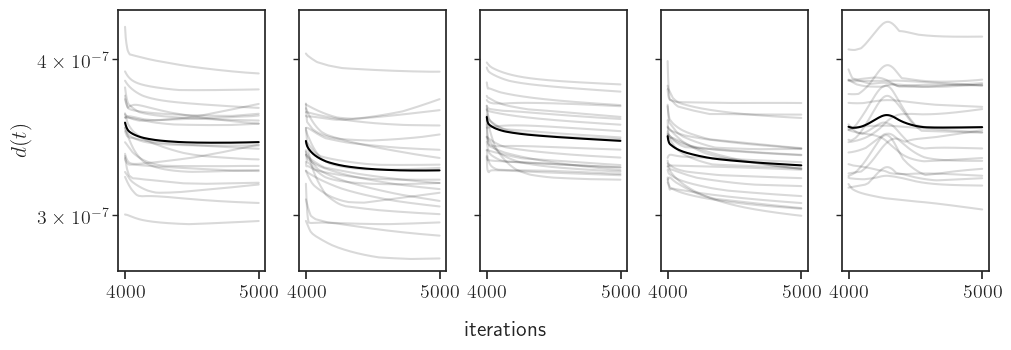

In [90]:
# Post-learning perturbations
with h5py.File('results/post_learn.h5', 'r') as f :
    weights_ds = f['weights']
    # print(dict(f.attrs))
    iters = np.arange(f.attrs['epochs_eff']-f.attrs['post_learn_epochs'], f.attrs['epochs_eff'])

    eps_idx = 10
    dists = np.squeeze(iris_train.get_dists_dataset_frommat(weights_ds[eps_idx,1::2][None,...]))

    loss_sample_period = 10
    # model = iris_train.get_empty_model(h_dim)
    # losses = np.empty((f.attrs['n_init'], f.attrs['n_pert'], f.attrs['n_sample_points']//loss_sample_period))
    # for i_init in range(f.attrs['n_init']) :
    #     for i_pert in range(f.attrs['n_pert']) :
    #         losses[i_init,i_pert] = iris_train.get_loss_from_matrices(weights_ds[i_init,i_pert,::loss_sample_period], model, x_train, y_train)

    
    n_init = f.attrs['n_init'] // 2

fig, axs = plt.subplots(1, n_init, figsize=(10, 3), constrained_layout=True, sharey=True)
fig.set_constrained_layout_pads(wspace=None)

twins = []
for i_init in range(n_init) :
    ax = axs[i_init]
    # d = dists[eps_idx,i_init,:,::loss_sample_period]
    d = dists[i_init,:]
    # iters = np.arange(0, f.attrs['n_sample_points'], loss_sample_period)

    ax.plot(iters, d.T, color='black', alpha=0.15, zorder=4)
    ax.plot(iters, np.mean(d.T, axis=1), color='black', zorder=5)
    # ax.set_xlabel('iterations')

    # ax.set_xscale('log')
    ax.set_yscale('log')

    # ax_ls = ax.twinx()
    # ax_ls.plot(iters, losses[i_init].T, color='darkblue', ls='--', alpha=0.1)
    # ax_ls.tick_params(colors='darkblue', which='both')
    # twins.append(ax_ls)
# ax_ls.set_ylabel("$\mathcal{L}$")
# ax_ls.get_shared_y_axes().join(*twins)
# for ax in twins[:-1] : ax.tick_params(right=False, labelright=False, which='both')

axs[0].set_ylabel('$d(t)$')
fig.text(0.5, -0.1, 'iterations', ha='center')

plt.savefig('../report/figures/epsilon_post_learn.pdf', bbox_inches='tight')

In [61]:
dists.shape

(0, 5, 20, 1000)

## 4.3 — Distance norm

1e-08


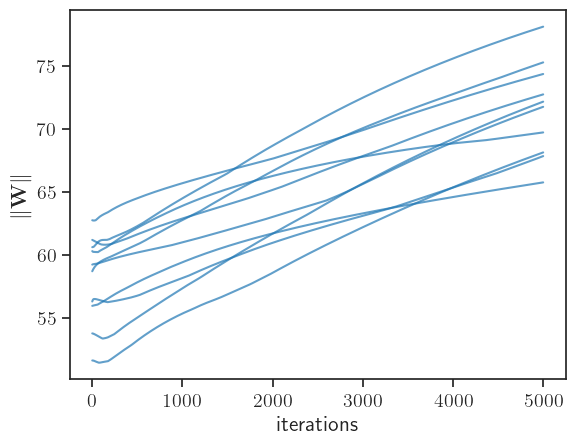

In [65]:
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']

    i_init = 0

    epsilons = f.attrs['epsilons']
    eps_idx = 10
    print(epsilons[eps_idx])

    ws = weights_ds[eps_idx, :, 0, ...]

    norms = np.sum(np.abs(ws), axis=(-2, -1))

plt.plot(norms.T, color='tab:blue', alpha=0.7);
plt.xlabel('iterations')
plt.ylabel('$\|\mathbf{W}\|$')

plt.savefig('../report/figures/weight_norm.pdf')

## 4.4 — Neutral drift?

/var/folders/17/j4v928fn43lgly2gzf268j480000gn/T/ipykernel_84531/3471292764.py:15: RuntimeWarning: divide by zero encountered in divide
  deltas = np.abs(ws[-1] - ws[0])/np.abs(ws[0])


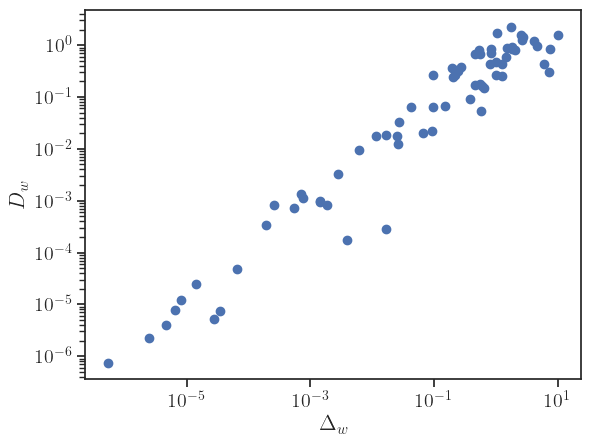

In [67]:
# Weight displacements vs distance
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']

    i_eps = 10
    i_init = 0

    # fig, axs = plt.subplots(5, 2, figsize=(6, 12))
    
    ws = weights_ds[i_eps,i_init,0]

ws = ws.reshape(ws.shape[0],-1)
ws = ws[:,~np.all(ws == 0, axis=0)]     # Exclude buffer weights
# ax.hist(np.abs(ws[-1] - ws[0]), bins=np.linspace(-2,2,20))
deltas = np.abs(ws[-1] - ws[0])/np.abs(ws[0])
change_total = np.sum(np.abs(ws[1:] - ws[:-1]), axis=0)

plt.scatter(deltas, change_total)
plt.xscale('log')
plt.yscale('log')

plt.xlabel("$\Delta_w$")
plt.ylabel("$D_w$")

# plt.tight_layout()
plt.savefig('../report/figures/weight_delta_dist.pdf')

/Users/kalo/.pyenv/versions/3.10.8/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


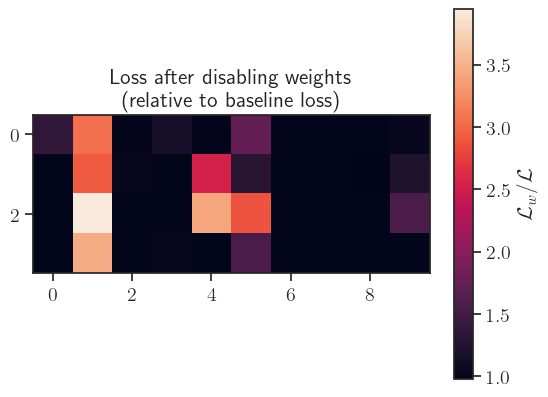

In [71]:
# Weight "feature importance"
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']

    i_eps = 10
    i_init = 7

    ws = np.squeeze(iris_train.matrices_to_weights_list(weights_ds[i_eps,i_init,0][None,...], *iho))

model = iris_train.get_empty_model(h_dim)
w_final = ws[-1]
model.set_weights(w_final)
l_baseline = model.loss(y_train, model(x_train)).numpy()

w_id = 0

input_shape = w_final[w_id].shape
l_change = np.empty(input_shape)
for i in range(input_shape[0]) :
    for j in range(input_shape[1]) :
        w = [m.copy() for m in w_final]
        w[w_id][i,j] = 0
        model.set_weights(w)
        l = model.loss(y_train, model(x_train)).numpy()
        l_change[i,j] = l / l_baseline       # Relative to magnitude of baseline loss

plt.imshow(l_change)
plt.title(f"Loss after disabling weights \n(relative to baseline loss)")
plt.colorbar(label="$\mathcal{L}_w/\mathcal{L}$")
l_baseline

plt.savefig('../report/figures/weight_loss.pdf')

Text(0, 0.5, 'L')

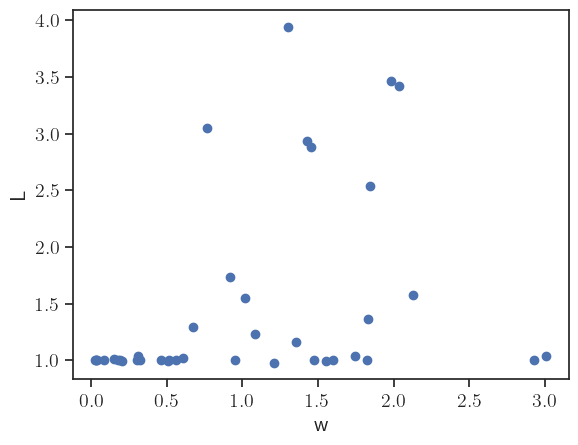

In [82]:
plt.scatter(np.abs(w_final[0].flatten()), l_change.flatten())
plt.xlabel('w')
plt.ylabel('L')

1e-08


/var/folders/17/j4v928fn43lgly2gzf268j480000gn/T/ipykernel_11780/1331545205.py:18: RuntimeWarning: divide by zero encountered in divide
  ax.hist((np.abs(ws[:,-1] - ws[:,0])/np.abs(ws[:,0])).flatten(), bins=np.linspace(0,2,20))


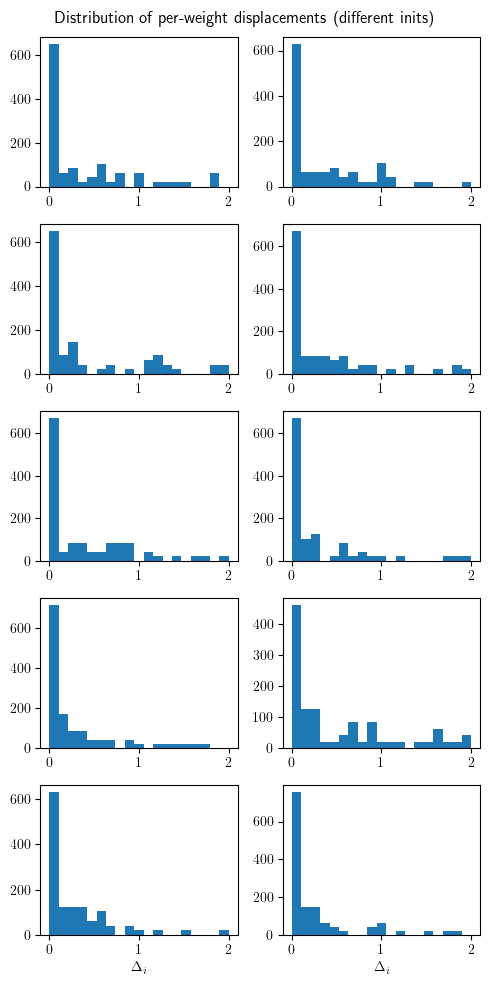

In [110]:
# Distribution of absolute changes (last - first) — "per-weight displacements"
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']
    # loss_ds = f['loss']

    eps_idx = 10
    print(f.attrs['epsilons'][eps_idx])

    fig, axs = plt.subplots(5, 2, figsize=(5, 10))

    for i, ax in enumerate(axs.flatten()) :
        ws = weights_ds[eps_idx,i]
        ws = ws.reshape(ws.shape[0], ws.shape[1], -1)   # Flatten out weight matrices
        ws = ws[:,:,~np.all(ws == 0, axis=(0,1))]     # Exclude buffer weights
        # vals = (np.abs(ws[:,-1] - ws[:,0])/np.abs(ws[:,0])).flatten()
        # hist, edges = np.histogram(vals, np.linspace(0,2,20))
        # ax.plot(edges[:-1], hist, 'o')
        ax.hist((np.abs(ws[:,-1] - ws[:,0])/np.abs(ws[:,0])).flatten(), bins=np.linspace(0,2,20))
        # ax.set_xscale('log')
        # ax.set_yscale('log')
    
    for ax in axs[-1] : ax.set_xlabel("$\Delta_i$")
    
    fig.suptitle("Distribution of per-weight displacements (different inits)")
    plt.tight_layout()
    plt.savefig('../report/figures/weight_delta.pdf')

# 5 — Large $\eta$

## 5.1 — Edge of Stability

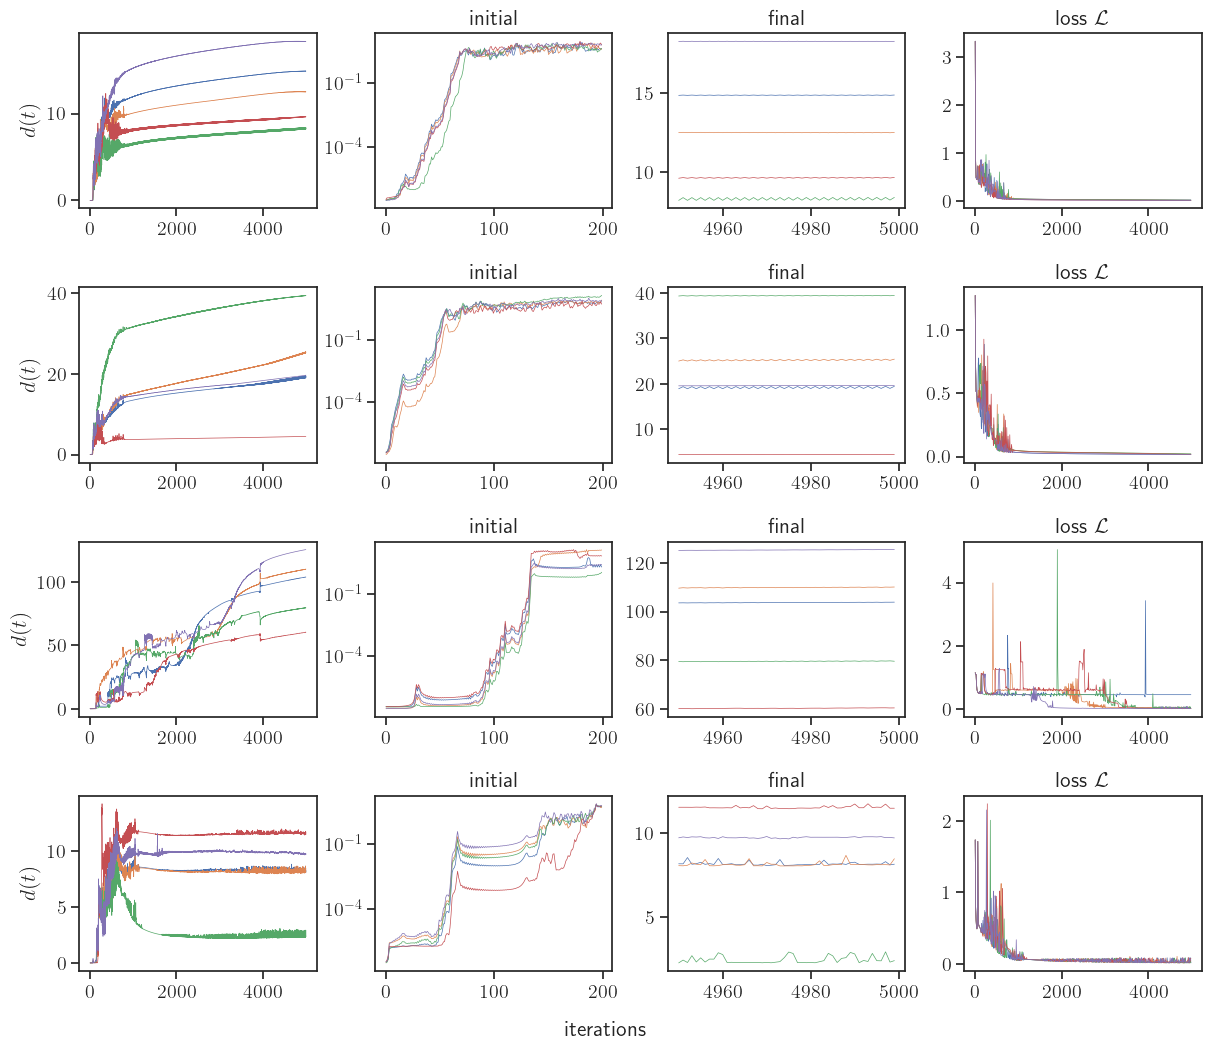

In [85]:
with open('../src/results/eos_perts.pkl', 'rb') as f :
    ws_chaotic_1 = pickle.load(f)
with open('../src/results/eos_perts_loss.pkl', 'rb') as f :
    ls_chaotic_1 = pickle.load(f)

dists = np.squeeze(iris_train.get_dists_dataset_frommat(ws_chaotic_1[None, 1::2]))
ls_chaotic_1 = ls_chaotic_1[1::2]

# n_init = ws_chaotic_1.shape[0]
n_init = 4

fig, axs = plt.subplots(n_init, 4, figsize=(12,n_init*2.5), layout='constrained')
fig.set_constrained_layout_pads(hspace=0.1)

for i_init in range(n_init) :
    ax_row = axs[i_init]
    ax_row[0].plot(dists[i_init].T, lw=0.5)
    ax_row[0].set_ylabel("$d(t)$")

    ax_row[1].set_title("initial")
    rang = (0, 200)
    ax_row[1].plot(range(*rang), dists[i_init, :, rang[0]:rang[1]].T, lw=0.5)
    ax_row[1].set_yscale('log')

    ax_row[2].set_title("final")
    n_fin = 50
    ax_row[2].plot(range(dists.shape[2]-n_fin, dists.shape[2]), dists[i_init, :, -n_fin:].T, lw=0.5)

    ax_row[3].plot(np.arange(0,5000,10), ls_chaotic_1[i_init].T, lw=0.5)
    # ax_row[3].plot(ls_chaotic_1[i_init, :, 50:150].T, lw=0.5)
    ax_row[3].set_title("loss $\mathcal{L}$")

fig.text(0.5, -0.03, 'iterations', ha='center')
plt.savefig('../report/figures/eos.pdf', bbox_inches='tight')

[  0.16849854 -20.83655588]
[0.87147525]


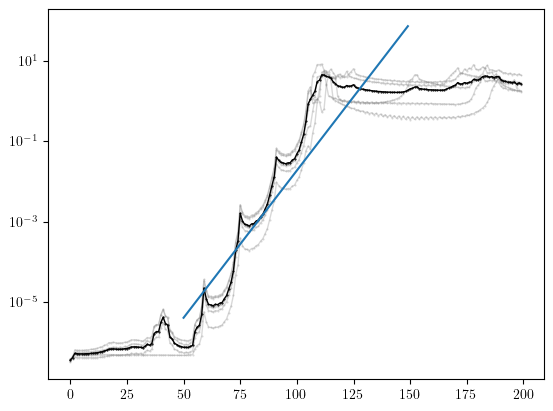

In [70]:
# with open('../src/results/eos_perts.pkl', 'rb') as f :
#     ws_chaotic_1 = pickle.load(f)
# with open('../src/results/eos_perts_loss.pkl', 'rb') as f :
#     ls_chaotic_1 = pickle.load(f)

dists = np.squeeze(iris_train.get_dists_dataset_frommat(ws_chaotic_1[None, :]))
n_init = ws_chaotic_1.shape[0]

i_init = 2
d = dists[i_init,:,:200].T
plt.plot(d, '.-', ms=1, lw=1, color='gray', alpha=0.3);
plt.plot(np.mean(d, axis=1), '.-', ms=1, lw=1, color='black');
plt.yscale('log')
# plt.xscale('log')

fit_window = (50,150)
y = np.log(np.mean(d, axis=1))[fit_window[0]:fit_window[1]]
x = range(*fit_window)
a, ssr, *_ = np.polyfit(x, y, deg=1, full=True)
sst = np.sum((y - np.mean(y))**2)
print(a)

# plt.figure()
plt.plot(x, np.exp(a[0]*x + a[1]))

rsq = 1 - ssr/sst
print(rsq)

/Users/kalo/.pyenv/versions/3.10.8/envs/tfm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kalo/.pyenv/versions/3.10.8/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kalo/.pyenv/versions/3.10.8/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kalo/.pyenv/versions/3.10.8/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/kalo/.pyenv/versions/3.10.8/envs/tfm/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.

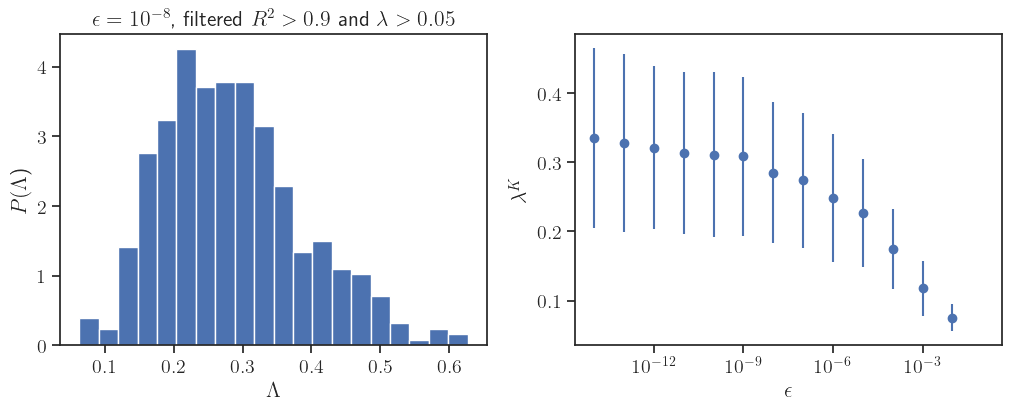

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(10,4), layout='constrained')
fig.set_constrained_layout_pads(wspace=0.05)

step = 5
mins, windows = np.mgrid[0:100+step:step, 30:100+step:step]
maxs = mins + windows

n_init = 500

###

with h5py.File('results/eos_exponent_eps.h5', 'r') as f :
    weights_ds = f['weights']
    epsilons = f.attrs['epsilons']
    dists_eps = iris_train.get_dists_dataset_frommat(weights_ds)

rs = np.empty((len(epsilons), n_init, *mins.shape))
slopes = np.empty((len(epsilons), n_init, *mins.shape))

for i_eps, eps in enumerate(epsilons) :
    dists = dists_eps[i_eps]
    for i in range(mins.shape[0]) :
        for j in range(mins.shape[1]) :
            x1, x2 = mins[i,j], maxs[i,j]
            
            d = np.mean(dists[:, :, x1:x2], axis=1).T
            
            # Do fit of log-norm data
            y = np.log(d)
            x = np.arange(x1,x2)
            a, ssr, *_ = np.polyfit(x, y, deg=1, full=True)
            sst = np.sum((y - np.mean(y, axis=0))**2, axis=0)
            
            rs[i_eps,:,i,j] = 1 - ssr/sst
            slopes[i_eps,:,i,j] = a[0]

best_slopes_idx = np.empty(rs.shape[0:2], dtype=int)     # One (flattened) idx for each init
best_slopes = np.empty(rs.shape[0:2])
best_slopes_r2 = np.empty(rs.shape[0:2])
for i_eps, rs_eps in enumerate(rs) :
    for i_init, rs_init in enumerate(rs_eps) :
        max_r_idx = np.argmax(rs_init)
        best_slopes_idx[i_eps,i_init] = max_r_idx
        best_slopes[i_eps,i_init] = slopes[i_eps,i_init].flatten()[max_r_idx]
        best_slopes_r2[i_eps,i_init] = np.max(rs_init)

r2_threshold = 0.9
slope_threshold = 0.05
best_slopes_filter_val = []
slope_means = []
slope_stds = []
for i_eps, eps in enumerate(epsilons) :
    best_slopes_filter_val.append(best_slopes[i_eps, (best_slopes_r2[i_eps] > r2_threshold) & (best_slopes[i_eps] > slope_threshold)])

    slope_means.append(np.mean(best_slopes_filter_val[i_eps]))
    slope_stds.append(np.std(best_slopes_filter_val[i_eps]))

i_eps = 6
# best_slopes_filter_val = best_slopes[e][(best_slopes_r2[e] > r2_threshold) & (best_slopes[e] > slope_threshold)]
axs[0].hist(best_slopes_filter_val[i_eps], bins=20, density=True);
axs[0].set_xlabel('$\Lambda$');
axs[0].set_ylabel('$P(\Lambda$)');
axs[0].set_title('$\epsilon=10^{-8}$, filtered $R^2>'+str(r2_threshold)+'$ and $\lambda>'+str(slope_threshold)+'$');

axs[1].errorbar(epsilons, slope_means, slope_stds, fmt='o')
axs[1].set_xscale('log')
axs[1].set_xlabel('$\epsilon$')
axs[1].set_ylabel('$\lambda^K$')
# axs[1].set_title("$\eta=1$")

plt.savefig('../report/figures/eos_mle.pdf')

## 5.2 — Fully-chaotic

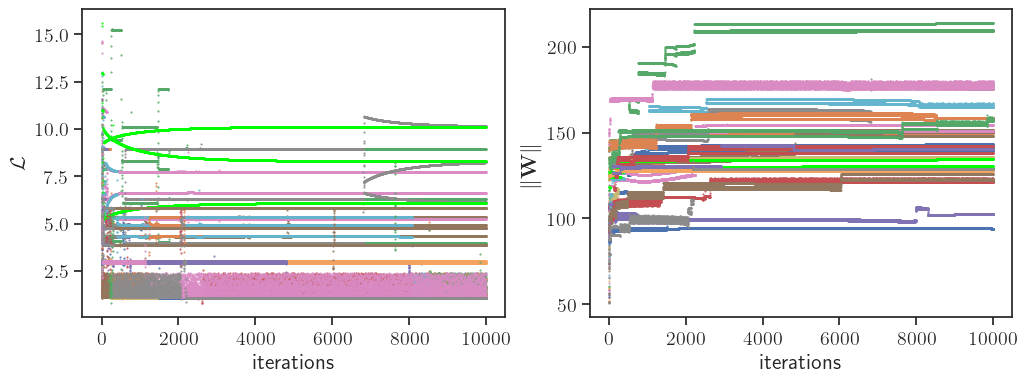

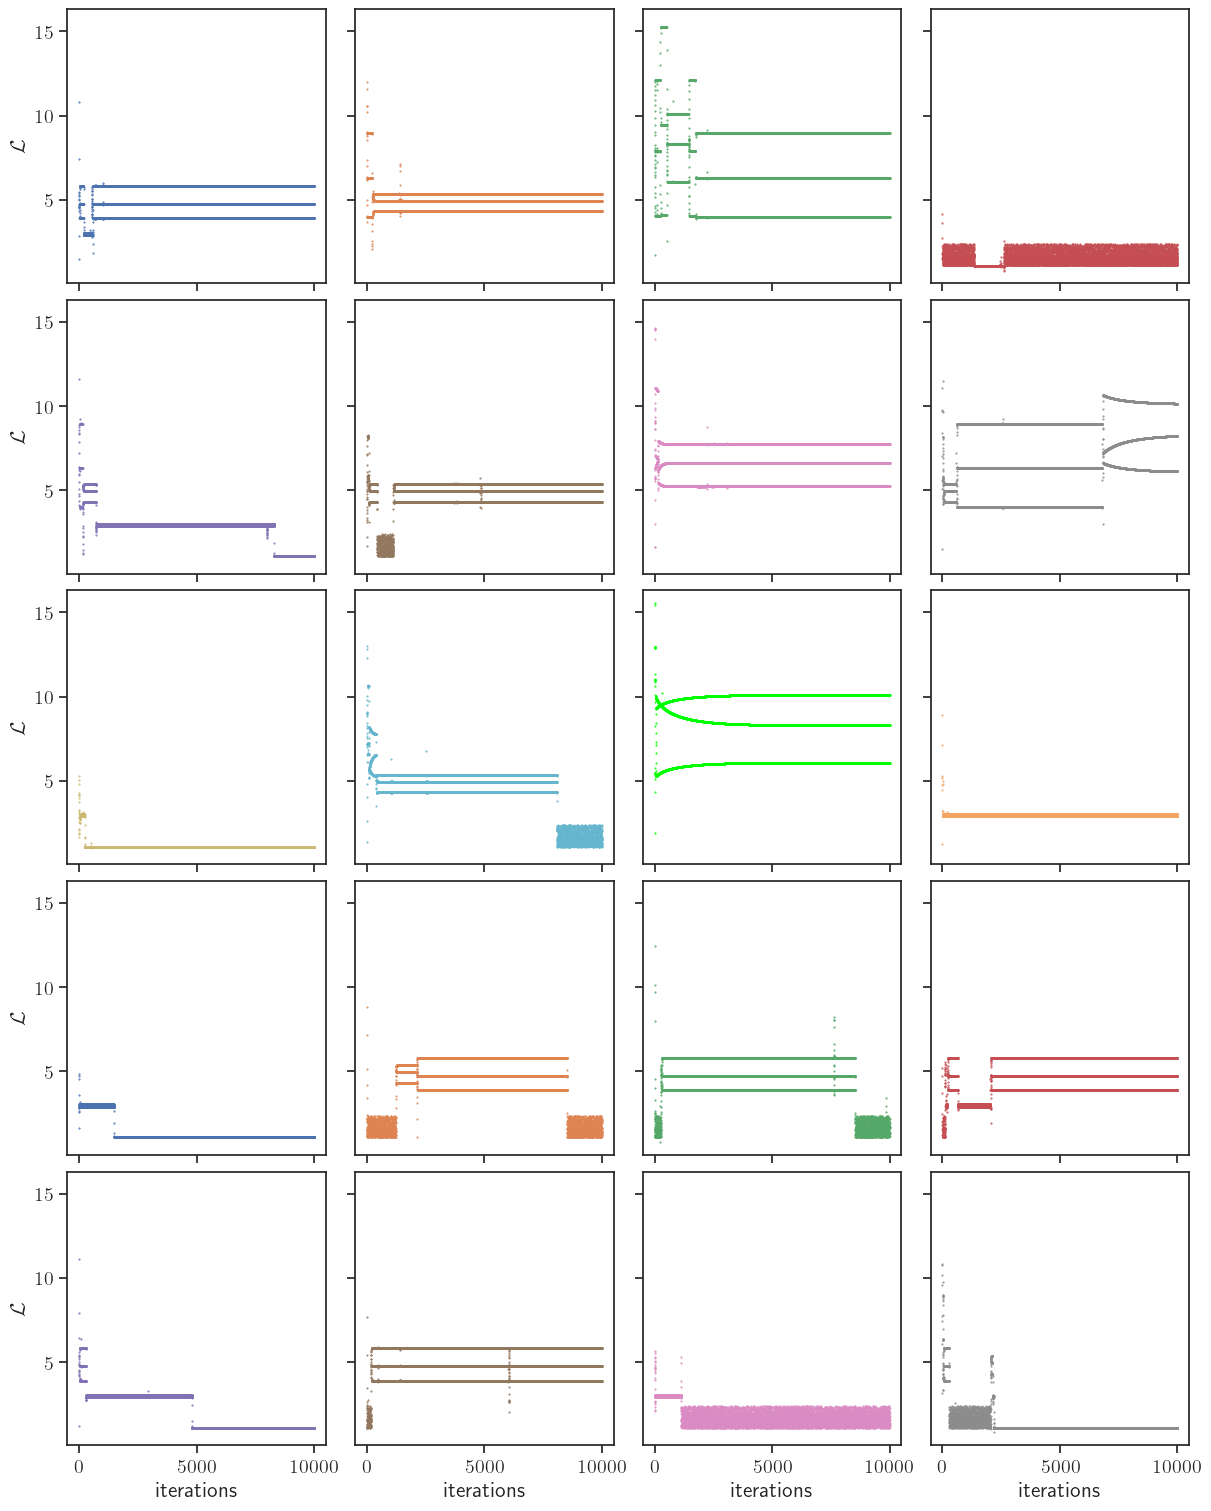

In [101]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + [mcolors.to_rgba(mcolors.CSS4_COLORS['lime']), mcolors.to_rgba(mcolors.CSS4_COLORS['sandybrown'])]

with h5py.File("results/chaotic.h5") as f :
    weights_ds = f['weights']
    loss_ds = f['loss']

    lr = f.attrs['lr']

    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    for i in range(loss_ds.shape[0]) :
        plt.plot(loss_ds[i].T, 'o', ms=0.5, color=colors[i%len(colors)]);

    # plt.title(f"$\eta={lr}$")
    plt.xlabel("iterations")
    plt.ylabel("$\mathcal{L}$")

    weight_norms = np.sum(np.abs(weights_ds), axis=(-2, -1))

    plt.subplot(122)
    for i in range(loss_ds.shape[0]) :
        plt.plot(weight_norms[i].T, 'o', ms=0.5, color=colors[i%len(colors)]);

    # plt.title(f"$\eta={lr}$, weight norms")
    plt.ylabel("$\|\mathbf{W}\|$")
    plt.xlabel('iterations')

    plt.savefig("../report/figures/chaotic_5.pdf", bbox_inches='tight')

    n_init = f.attrs['n_init']
    cols = 4
    rows = int(np.ceil(n_init / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(12, rows*3), layout='constrained', sharex=True, sharey=True)
    # fig.suptitle(f"$\eta={lr}$")

    axs_flat = axs.flatten()
    for i in range(n_init) :
        axs_flat[i].plot(loss_ds[i].T, 'o', ms=0.5, color=colors[i%len(colors)])

    for ax in axs[-1] : ax.set_xlabel("iterations")
    for ax in axs[:,0] : ax.set_ylabel("$\mathcal{L}$")

    plt.savefig("../report/figures/chaotic_5_inits.pdf", bbox_inches='tight')

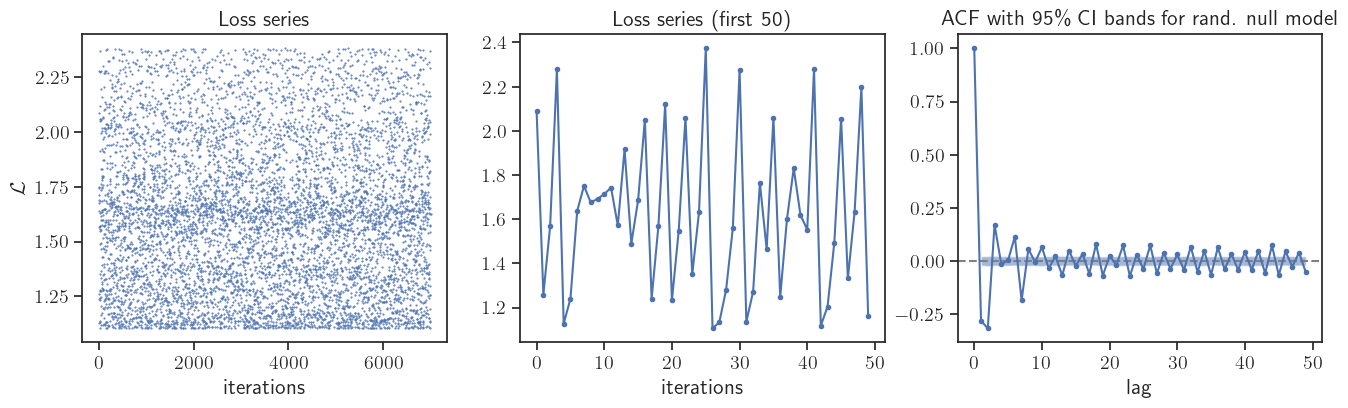

In [103]:
def get_acf(x) :
    n = len(x)
    mean = np.mean(x)
    var = np.var(x)

    # Compute autocovariance function
    x_norm = x - mean
    autocov = np.correlate(x_norm, x_norm, 'full')[n-1:]
    autocov = autocov / (n - np.arange(n))

    # Compute autocorrelation function
    acf = autocov / var

    return acf

def autocorr_ci(x, n_shuffle=100, CI=0.03):
    """
    Compute autocorrelation function of a time series and confidence intervals for a null model obtained by shuffling.

    Adapted from code by Lucas.
    """
    n = len(x)

    acf = get_acf(x)

    # Shuffle time series and compute autocorrelation function for each shuffle
    acf_null = np.zeros((n_shuffle, n))
    for i in range(n_shuffle):
        xx=x.copy()
        np.random.shuffle(xx)
        acf_null[i, :] = get_acf(xx)

    # Compute confidence intervals for null model
    ci_null = np.zeros((n, 2))
    for i in range(n):
        sorted_null = np.sort(acf_null[:, i])
        # Not ideal but close enough...
        ci_null[i,0] = sorted_null[int(n_shuffle*CI)]
        ci_null[i,1]  = sorted_null[int(n_shuffle*(1-CI))]
    
    return acf, ci_null

with h5py.File("results/chaotic.h5") as f :
    loss_ds = f['loss']
    x = loss_ds[3, 3000:]

    x_norm = x - np.mean(x)
    corr, ci = autocorr_ci(x_norm, n_shuffle=1000, CI=0.03)

fig, axs = plt.subplots(1, 3, figsize=(16,4))

axs[0].set_title("Loss series")
axs[0].plot(x, '.', ms=1)
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('$\mathcal{L}$')

lim = 50
axs[1].set_title(f'Loss series (first {lim})')
axs[1].plot(x[:lim], '.-')
axs[1].set_xlabel('iterations')
# axs[1].set_ylabel('Loss')

lim = 50
axs[2].set_title('ACF with 95\% CI bands for rand. null model')
axs[2].axhline(0, ls='--', color='gray')
axs[2].fill_between(range(lim), ci[:lim,0], ci[:lim,1], alpha=0.5)
axs[2].plot(corr[:lim], '.-');
axs[2].set_xlabel('lag')

plt.savefig('../report/figures/chaotic_acf.pdf', bbox_inches='tight')

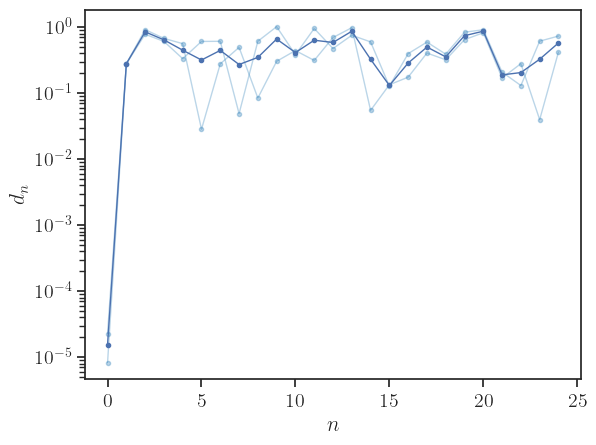

In [107]:
# x for long trajectory
with h5py.File('results/chaotic_inter.h5', 'r') as f :
    loss_ds = f['loss']

    x = loss_ds[2700:45000]

rng = np.random.default_rng(1)
n_sample = 100
while True :
    p0s_idx = rng.integers(0, x.shape[0], n_sample)
    if len(np.unique(p0s_idx)) == n_sample : break

e = 5e-5
p1s_idx = []
x_idx = np.arange(len(x))
for p0 in p0s_idx :
    p1s_idx.append(x_idx[(x < x[p0]+e) & (x > x[p0]-e) & (x != x[p0])])

trajectories = []
for i in range(n_sample) :
    p0_traj = x[p0s_idx[i]:]
    p1s_traj = []
    for p1 in p1s_idx[i] :
        p1s_traj.append(x[p1:])
    
    trajectories.append((p0_traj, p1s_traj))

p0_idx = 16
t1 = trajectories[p0_idx][0]
t2s = trajectories[p0_idx][1]

lim = 25
ds = np.zeros(lim)
for t2 in t2s :
    n_max = max(len(t1), len(t2))
    t1 = np.pad(t1, (0, n_max-len(t1)), mode='constant', constant_values=None)
    t2 = np.pad(t2, (0, n_max-len(t2)), mode='constant', constant_values=None)
    # distance = t1 - t2
    d = np.abs(t1 - t2)[:lim]
    ds += d
    plt.plot(d, '.-', lw=1, color='tab:blue', alpha=0.3);

plt.plot(ds/len(t2s), '.-', lw=1, color=colors[0]);
plt.yscale('log')
plt.xlabel("$n$")
plt.ylabel("$d_n$")

plt.savefig('../report/figures/chaotic_diverge.pdf')

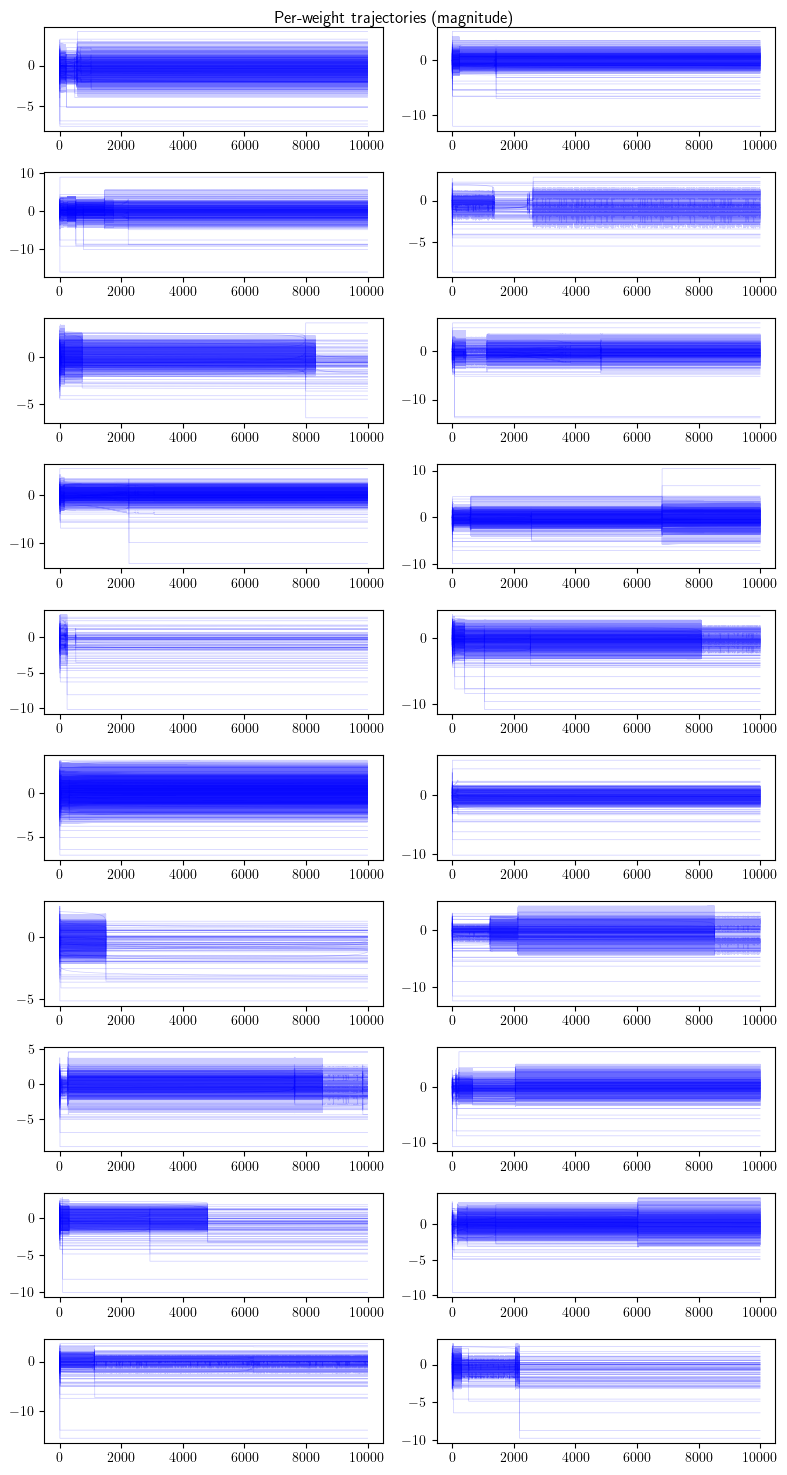

In [74]:
# Individual weights
with h5py.File('results/chaotic.h5', 'r') as f :
    weights_ds = f['weights']
    loss_ds = f['loss']

    # i_eps = 10

    fig, axs = plt.subplots(10, 2, figsize=(8, 15))

    for i, ax in enumerate(axs.flatten()) :
        ws = weights_ds[i]
        ws = ws.reshape(ws.shape[0],-1)
        ax.plot(ws[:,~np.all(ws == 0, axis=0)], color='blue', alpha=0.2, lw=0.5)
    
    fig.suptitle("Per-weight trajectories (magnitude)")
    plt.tight_layout()
    plt.savefig('../report/figures/chaotic_weights_all.pdf')

(10000, 208)
(10000, 83)
(10000, 9)


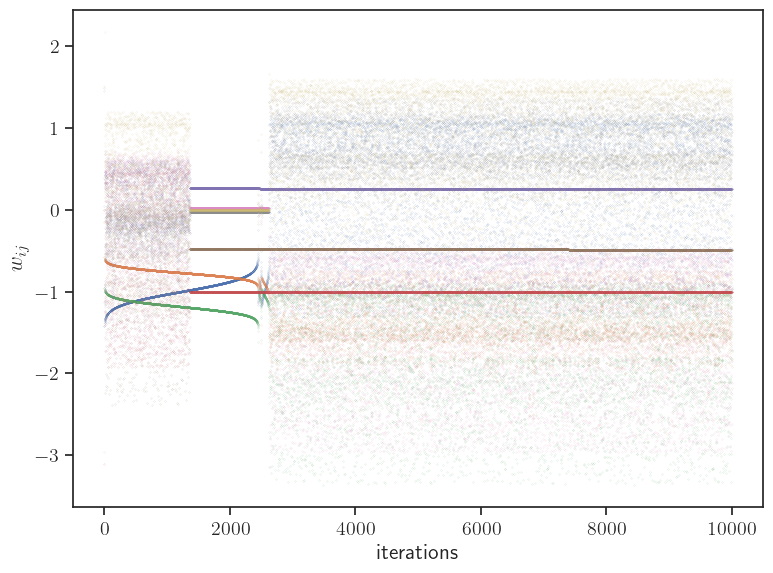

In [98]:
with h5py.File('results/chaotic.h5', 'r') as f :
    weights_ds = f['weights']
    loss_ds = f['loss']

    # i_eps = 10
    i_init = 3

    fig = plt.figure(figsize=(8, 6))
    ax = plt.gca()

    ws = weights_ds[i_init]
    ws = ws.reshape(ws.shape[0],-1)
    print(ws.shape)
    ws = ws[:,~np.all(ws == 0, axis=0)]     # Remove buffer weights
    print(ws.shape)
    change_threshold = 15
    ws_change = np.sum(np.abs(ws[1:,:] - ws[:-1,:]), axis=0)
    ws = ws[:, ws_change > change_threshold]     # Remove trajectories that dont change much
    print(ws.shape)
    
    ax.plot(ws, '.', alpha=0.7, ms=0.2)
    # ax.set_title("Per-weight trajectories (magnitude)")
    ax.set_xlabel("iterations")
    ax.set_ylabel("$w_{ij}$")
    
    plt.tight_layout()
    plt.savefig('../report/figures/chaotic_weights_individual.pdf')

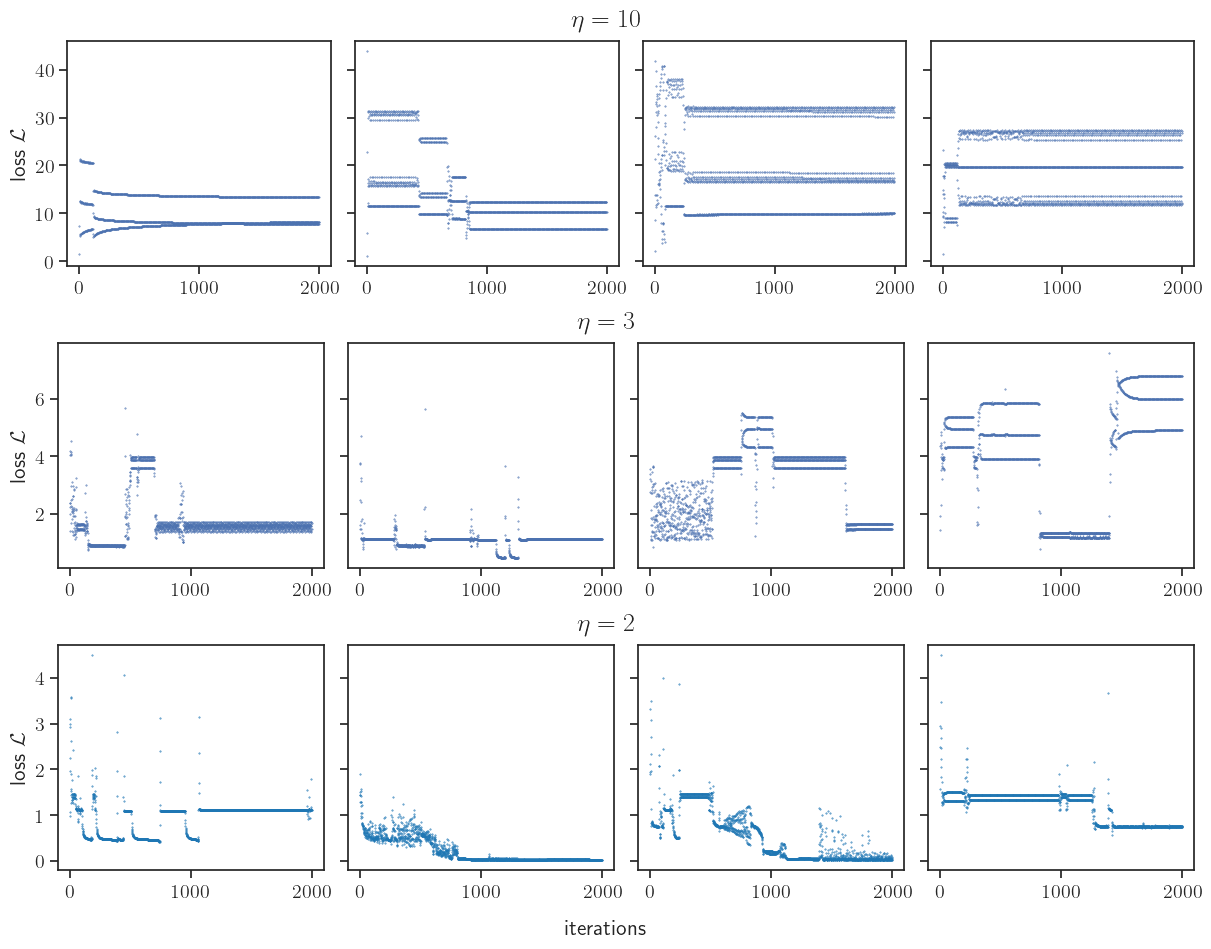

In [104]:
fig = plt.figure(layout='constrained', figsize=(12, 9))
subfigs = fig.subfigures(3, 1, wspace=0.07)

###

with open("results/chaotic_10.pkl", 'rb') as f : weights_ds = pickle.load(f)
with open("results/chaotic_10_loss.pkl", 'rb') as f : loss_ds = pickle.load(f)

max_iter = loss_ds.shape[1]

subfigs[0].suptitle("$\eta=10$")
axs = subfigs[0].subplots(1, 4, sharex=True, sharey=True)
init_idx = [0, 1, 8, 10]
for i, i_init in enumerate(init_idx) :
    axs[i].plot(range(max_iter), loss_ds[i_init].T, 'o', ms=0.4, color=colors[0]);
    # axs[i].set_xlabel("iteration")
axs[0].set_ylabel("loss $\mathcal{L}$")

###

with open("results/chaotic_3.pkl", 'rb') as f : weights_ds = pickle.load(f)
with open("results/chaotic_3_loss.pkl", 'rb') as f : loss_ds = pickle.load(f)

subfigs[1].suptitle("$\eta=3$")
axs = subfigs[1].subplots(1, 4, sharex=True, sharey=True)
init_idx = [0, 1, 9, 10]
for i, i_init in enumerate(init_idx) :
    axs[i].plot(range(max_iter), loss_ds[i_init].T, 'o', ms=0.4, color=colors[0]);
    # axs[i].set_xlabel("iteration")
axs[0].set_ylabel("loss $\mathcal{L}$")

###

with open("results/chaotic_2.pkl", 'rb') as f : weights_ds = pickle.load(f)
with open("results/chaotic_2_loss.pkl", 'rb') as f : loss_ds = pickle.load(f)

subfigs[2].suptitle("$\eta=2$")
axs = subfigs[2].subplots(1, 4, sharex=True, sharey=True)
init_idx = [0, 1, 3, 8]
for i, i_init in enumerate(init_idx) :
    axs[i].plot(range(max_iter), loss_ds[i_init].T, 'o', ms=0.4, color=[0]);
    # axs[i].set_xlabel("iteration")
axs[0].set_ylabel("loss $\mathcal{L}$")

subfigs[2].text(0.5, -0.1, 'iterations', ha='center')
# fig.add_subplot(111, frameon=False, zorder=100)
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# plt.xlabel("common X")

plt.savefig("../report/figures/chaotic_alt.pdf", bbox_inches='tight')

del weights_ds
del loss_ds

# Appendix — Full results

[1.e-15 1.e-14 1.e-13 1.e-12 1.e-11 1.e-10 1.e-09 1.e-08 1.e-07 1.e-06
 1.e-05 1.e-04 1.e-03 1.e-02]


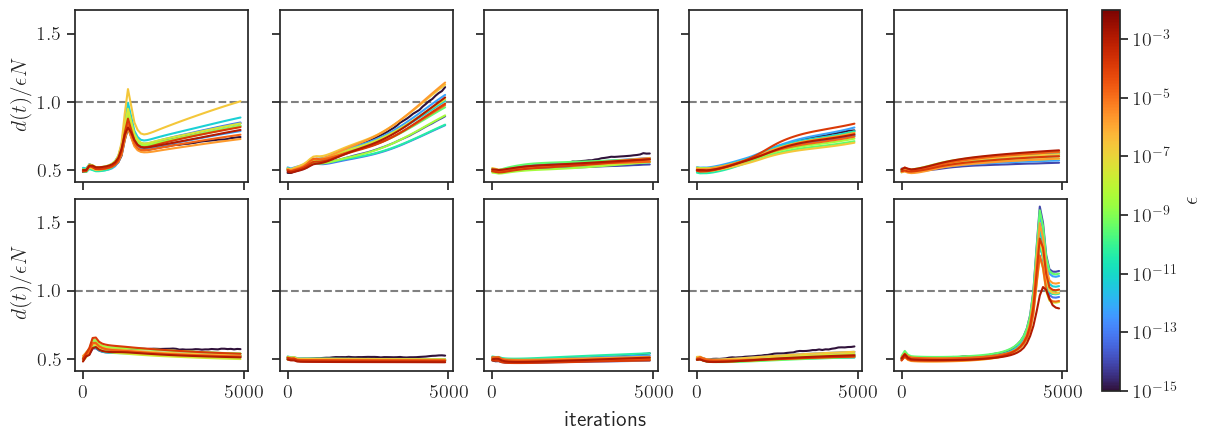

In [61]:
# Init perturb, normalized by epsilon
with h5py.File('results/epsilon_full.h5', 'r') as f :
    weights_ds = f['weights']

    n_init = f.attrs['n_init']
    n_pert = f.attrs['n_pert']
    # i_init = 0

    epsilons = f.attrs['epsilons']
    # eps_indices = [4, 8, 12, 16]
    eps_indices = range(3, len(epsilons)-5)
    print(epsilons[eps_indices])

    period = 100
    dists_all = iris_train.get_dists_dataset_frommat(weights_ds[:,:,:,::period,...])
    iter = np.arange(0, f.attrs['n_sample_points'], period)

norm_factors = 70 * epsilons    # number of neurons * pert radius = max pert distance

fig = plt.figure(figsize=(12,4), layout='constrained')
# fig.set_constrained_layout_pads(wspace=0.1)
subfigs = fig.subfigures(1, 2, wspace=None, width_ratios=[10, 1])
axs_plot = subfigs[0].subplots(2, 5, sharex=True, sharey=True)
axs_cbar = subfigs[1].subplots(1, 1)

axs = axs_plot.flatten()

cmap = mpl.colormaps['turbo']
norm = mpl.colors.LogNorm(epsilons[eps_indices[0]], epsilons[eps_indices[-1]])

for i_ax, ax in enumerate(axs) :
    for i, i_eps in enumerate(eps_indices) :
        d = dists_all[i_eps,i_ax]/norm_factors[i_eps]
        ax.plot(iter, np.mean(d.T, axis=1), color=cmap(i/len(eps_indices)), alpha=1, zorder=5)

    ax.axhline(1, ls='--', color='gray')
axs_plot[0,0].set_ylabel('$d(t)/\epsilon N$')
axs_plot[1,0].set_ylabel('$d(t)/\epsilon N$')

plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), cax=axs_cbar, label='$\epsilon$')
fig.text(0.5, -0.05, 'iterations', ha='center')
plt.savefig('../report/figures/epsilon_full_norm.pdf', bbox_inches='tight')

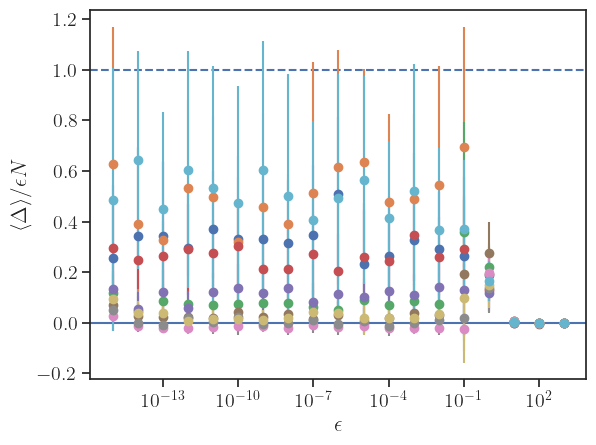

In [64]:
plt.axhline(0)
plt.axhline(1, ls='--')

for i_init in range(n_init) :
    # get average final dist
    dists_avg = np.mean(dists_all[3:, i_init, ...], axis=1)
    d_final = dists_avg[:,-1]
    dists_std = np.std(dists_all[3:, i_init, ...], axis=1)
    d_final_std = dists_std[:,-1]

    d_final = np.mean(dists_all[3:,i_init,:,-1,...] - dists_all[3:,i_init,:,0,...], axis=1)
    d_final_std = np.std(dists_all[3:,i_init,:,-1,...] - dists_all[3:,i_init,:,0,...], axis=1)

    # normalize and plot as function of delta / d0_exp
    d_final_norm = d_final / norm_factors[3:]
    d_final_std_norm = d_final_std / norm_factors[3:]

    plt.errorbar(epsilons[3:], d_final_norm, yerr=d_final_std_norm, fmt='o')
plt.xlabel('$\epsilon$')
plt.ylabel('$\langle\Delta\\rangle / \epsilon N$')
plt.xscale('log')
# plt.yscale('log')
# plt.title("Final distance relative to size of 'ball'")

[1.e-15 1.e-14 1.e-13 1.e-12 1.e-11 1.e-10 1.e-09 1.e-08 1.e-07 1.e-06
 1.e-05 1.e-04 1.e-03 1.e-02]


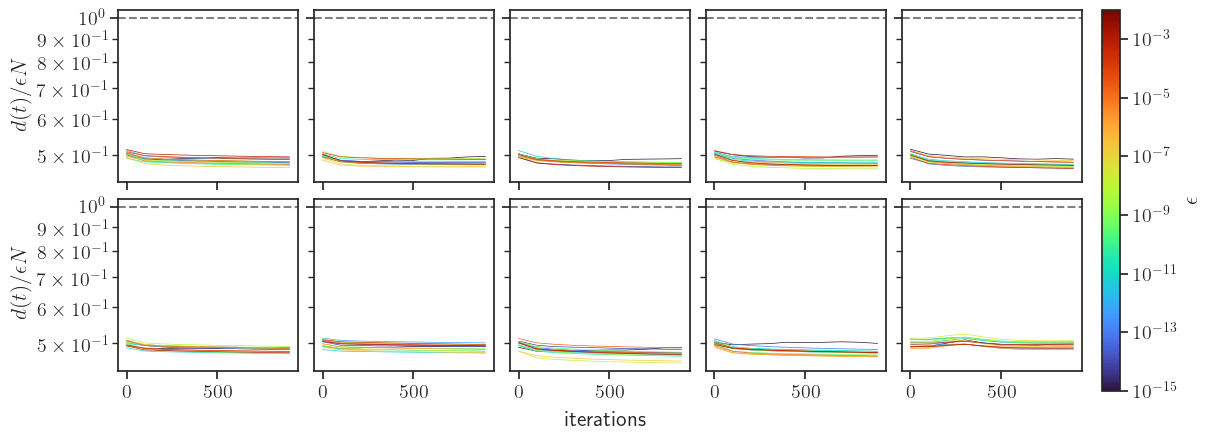

In [66]:
# Basin perturb, normalized by epsilon
with h5py.File('results/post_learn.h5', 'r') as f :
    weights_ds = f['weights']

    n_init = f.attrs['n_init']
    n_pert = f.attrs['n_pert']
    # i_init = 0

    epsilons = f.attrs['epsilons']
    # eps_indices = [4, 8, 12, 16]
    eps_indices = range(3, len(epsilons)-5)
    print(epsilons[eps_indices])

    period = 100
    dists_all = iris_train.get_dists_dataset_frommat(weights_ds[:,:,:,::period,...])
    iter = np.arange(0, f.attrs['n_sample_points'], period)

norm_factors = 70 * epsilons    # number of neurons * pert radius = max pert distance

fig = plt.figure(figsize=(12,4), layout='constrained')
# fig.set_constrained_layout_pads(wspace=0.1)
subfigs = fig.subfigures(1, 2, wspace=None, width_ratios=[10, 1])
axs_plot = subfigs[0].subplots(2, 5, sharex=True, sharey=True)
axs_cbar = subfigs[1].subplots(1, 1)

axs = axs_plot.flatten()

cmap = mpl.colormaps['turbo']
norm = mpl.colors.LogNorm(epsilons[eps_indices[0]], epsilons[eps_indices[-1]])

for i_ax, ax in enumerate(axs) :
    for i, i_eps in enumerate(eps_indices) :
        d = dists_all[i_eps,i_ax]/norm_factors[i_eps]
        ax.plot(iter, np.mean(d.T, axis=1), color=cmap(i/len(eps_indices)), alpha=1, zorder=5, lw=0.5)

    ax.axhline(1, ls='--', color='gray')
    ax.set_yscale('log')
axs_plot[0,0].set_ylabel('$d(t)/\epsilon N$')
axs_plot[1,0].set_ylabel('$d(t)/\epsilon N$')

plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), cax=axs_cbar, label='$\epsilon$')
fig.text(0.5, -0.05, 'iterations', ha='center')
plt.savefig('../report/figures/epsilon_post_learn_norm.pdf', bbox_inches='tight')

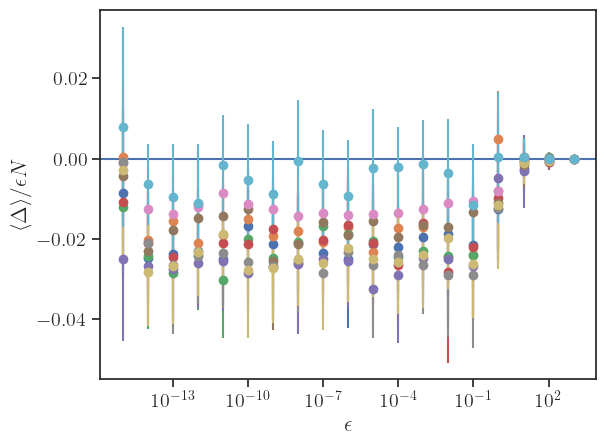

In [69]:
plt.axhline(0)
# plt.axhline(1, ls='--')

for i_init in range(n_init) :
    # get average final dist
    dists_avg = np.mean(dists_all[3:, i_init, ...], axis=1)
    d_final = dists_avg[:,-1]
    dists_std = np.std(dists_all[3:, i_init, ...], axis=1)
    d_final_std = dists_std[:,-1]

    d_final = np.mean(dists_all[3:,i_init,:,-1,...] - dists_all[3:,i_init,:,0,...], axis=1)
    d_final_std = np.std(dists_all[3:,i_init,:,-1,...] - dists_all[3:,i_init,:,0,...], axis=1)

    # normalize and plot as function of delta / d0_exp
    d_final_norm = d_final / norm_factors[3:]
    d_final_std_norm = d_final_std / norm_factors[3:]

    plt.errorbar(epsilons[3:], d_final_norm, yerr=d_final_std_norm, fmt='o')
plt.xlabel('$\epsilon$')
plt.ylabel('$\langle\Delta\\rangle / \epsilon N$')
plt.xscale('log')
# plt.yscale('log')
# plt.title("Final distance relative to size of 'ball'")